In [24]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [26]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [27]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [28]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [29]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


In [30]:
# feel free to play around with the rolling window

def calc_rolling_vola(returns, rolling_window=20, resample_period="ME"):
    # Optionally resample the data (if resample_period is provided, e.g., 'M' for monthly)
    if resample_period:
        returns_resampled = returns.resample(resample_period).apply(lambda x: (1 + x).prod() - 1)
    else:
        returns_resampled = returns
    
    # Calculate rolling volatility for each ETF (resampled data if applicable)
    rolling_volatility = returns_resampled.rolling(window=rolling_window).std()
    
    # Add suffix to column names to indicate rolling volatility
    rolling_volatility.columns = [f"{col}_rolling_vol" for col in returns_resampled.columns]
    
    # Combine original returns with rolling volatility for reference
    result = rolling_volatility.dropna()
    
    # Display the result
    return result
volatilities = calc_rolling_vola(returns)
volatilities['Aggregate'] = volatilities.mean(axis=1).dropna()

volatilities_avg = pd.DataFrame(index=volatilities.index)

volatilities_avg['Equities Avg'] = (
    1/5 * volatilities['Japan_rolling_vol'] + 
    1/5 * volatilities['Europe_rolling_vol'] + 
    1/5 * volatilities['LatAm_rolling_vol'] + 
    1/5 * volatilities['US_rolling_vol'] + 
    1/5 * volatilities['APACxJapan_rolling_vol']
)

volatilities_avg['Bonds Avg'] = (
    1/2 * volatilities['T-Bills_7_10_rolling_vol'] + 
    1/2 * volatilities['T-Bills_20_rolling_vol']
)

volatilities_avg['Gold Avg'] = volatilities['Gold_rolling_vol']


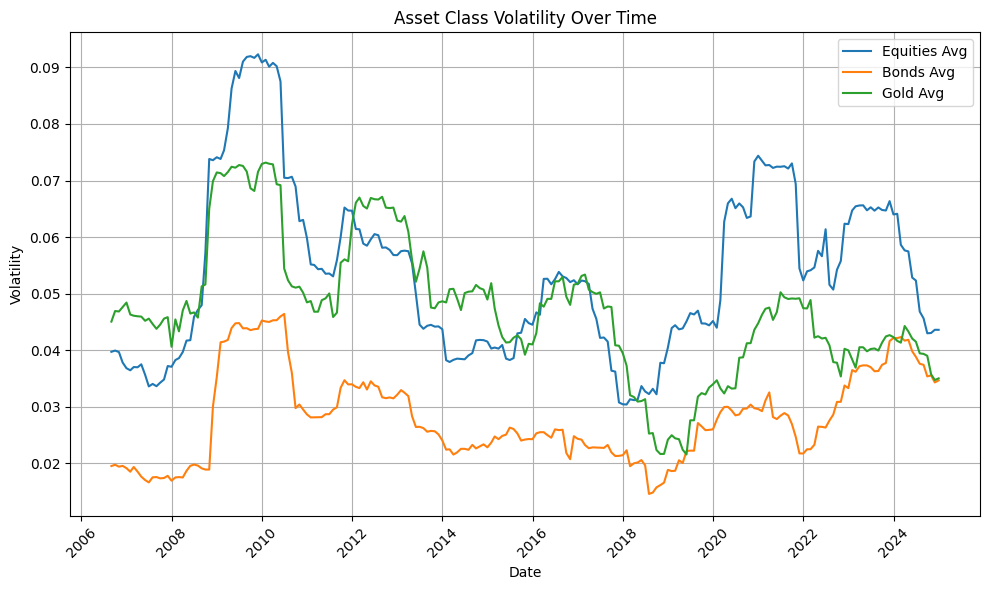

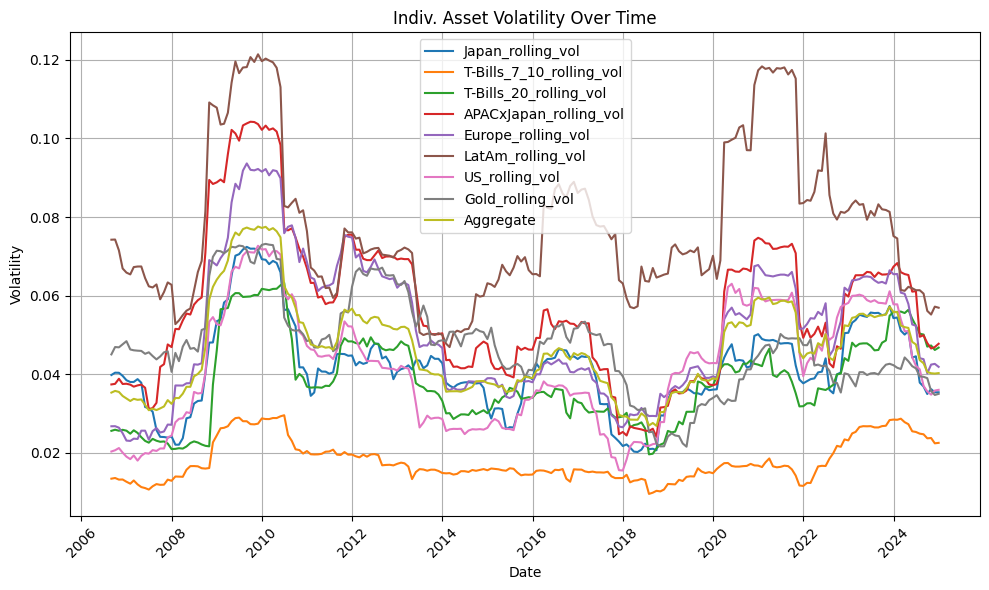

In [31]:
plt.figure(figsize=(10, 6))
for column in volatilities_avg.columns:
    plt.plot(volatilities_avg.index, volatilities_avg[column], label=column)
plt.title('Asset Class Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for column in volatilities.columns:
    plt.plot(volatilities.index, volatilities[column], label=column)
plt.title('Indiv. Asset Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
high_threshold = np.percentile(volatilities['Aggregate'], 67)
med_threshold = np.percentile(volatilities['Aggregate'], 33)

# Classify periods into 3 regimes
def classify_volatility(vol):
    if vol >= high_threshold:
        return 'High'
    elif vol >= med_threshold:
        return 'Medium'
    else:
        return 'Low'

volatilities['Volatility_Regime'] = volatilities['Aggregate'].apply(classify_volatility)
volatilities

,Japan_rolling_vol,T-Bills_7_10_rolling_vol,T-Bills_20_rolling_vol,APACxJapan_rolling_vol,Europe_rolling_vol,LatAm_rolling_vol,US_rolling_vol,Gold_rolling_vol,Aggregate,Volatility_Regime
Exchange Date,,,,,,,,,,
2006-08-31,0.039829,0.013463,0.025630,0.037430,0.026791,0.074241,0.020373,0.045072,0.035354,Low
2006-09-30,0.040418,0.013633,0.025913,0.037578,0.026809,0.074286,0.020689,0.046940,0.035783,Low
2006-10-31,0.040395,0.013224,0.025654,0.038873,0.026428,0.071512,0.021249,0.046862,0.035525,Low
2006-11-30,0.039615,0.013254,0.025888,0.037549,0.025029,0.066924,0.020093,0.047638,0.034499,Low
2006-12-31,0.038501,0.012682,0.025668,0.037607,0.023152,0.065870,0.019057,0.048435,0.033871,Low
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.036903,0.024748,0.050115,0.049932,0.043851,0.060526,0.037044,0.039367,0.042811,Medium
2024-09-30,0.035001,0.023728,0.047052,0.047961,0.040263,0.056141,0.035671,0.039027,0.040606,Medium
2024-10-31,0.036229,0.023804,0.047334,0.046569,0.042474,0.055206,0.034832,0.035760,0.040276,Medium


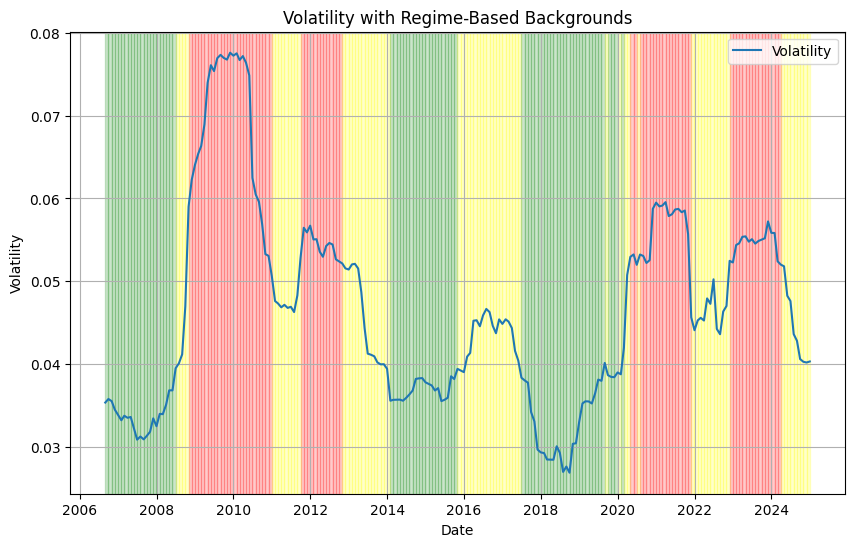

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(volatilities.index, volatilities['Aggregate'], label='Volatility')

# Add colored background based on volatility regime
for i in range(len(volatilities) - 1):  # Loop over rows, excluding the last row
    if volatilities['Volatility_Regime'].iloc[i] == 'Low':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='green', alpha=0.2)
    elif volatilities['Volatility_Regime'].iloc[i] == 'Medium':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='yellow', alpha=0.2)
    elif volatilities['Volatility_Regime'].iloc[i] == 'High':
        plt.axvspan(volatilities.index[i], volatilities.index[i + 1],
                    color='red', alpha=0.2)

# Add labels and legend
plt.title('Volatility with Regime-Based Backgrounds')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [34]:
volatility_switches = (volatilities[volatilities['Volatility_Regime'].shift() != volatilities['Volatility_Regime']]).index

print(f'Volatility regime switches:\n {volatility_switches}')

Volatility regime switches:
 DatetimeIndex(['2006-08-31', '2008-06-30', '2008-10-31', '2010-12-31',
               '2011-09-30', '2012-10-31', '2014-01-31', '2015-10-31',
               '2017-06-30', '2019-08-31', '2019-09-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-04-30', '2020-06-30',
               '2020-07-31', '2021-11-30', '2022-11-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Exchange Date', freq=None)
